# ***PS3***

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random as rand
from PIL import Image
from scipy.ndimage import rotate
import math

In [2]:
# grab the data
filepaths = {
    "x_train": "./trainX.txt",
    "y_train": "./trainY.txt",
    "x_test": "./testX.txt",
    "y_test": "./testY.txt"
}
x_train = pd.read_csv(filepaths["x_train"])
y_train = pd.read_csv(filepaths["y_train"])
x_test = pd.read_csv(filepaths["x_test"])
y_test = pd.read_csv(filepaths["y_test"])

print(x_train.shape)

(470, 784)


(784,)
(28, 28)


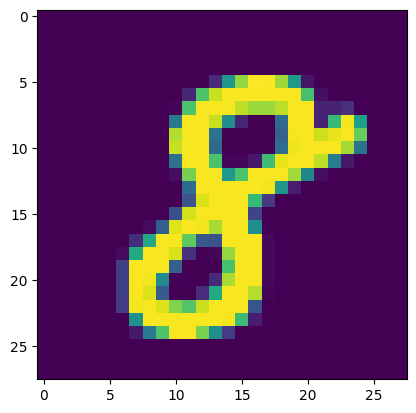

In [3]:
test = x_train.iloc[300, :].to_numpy()
test2 = test.reshape(28, 28)
print(test.shape)
print(test2.shape)
plt.imshow(test2)

## 1) **Bayesian Logistic Regression for Image Classification**

In [193]:
mat = np.arange(6).reshape((3,2))

vec = np.array(np.arange(2).reshape(2, 1))
print(mat)
print(vec)

lin_comb = np.exp(-mat @ vec)
print(np.sum(mat, axis = 0))



[[0 1]
 [2 3]
 [4 5]]
[[0]
 [1]]
[6 9]


In [297]:
# create bayesian logistic regression class object
class BayesianLogisticRegression:

  # member variables
  sigma = 1

  # constructor
  def __init__(self, sigma = 1):
    self.sigma = sigma
    self.beta = []

  # fitting
  def fit(self, X, Y, params = {"epsilon": .1, "learning_rate": .0001}, X_test = [], Y_test = []):
    # add bias to X data
    X_bias = np.hstack((np.ones(shape = (X.shape[0], 1)), X))
    X_bias_shape = X_bias.shape
    loss = []

    # randomly initialize beta
    self.beta = np.random.normal(0, self.sigma, size = (X_bias_shape[1], 1))

    likelihood_grad_norm = 100

    # calculate the gradient
    while likelihood_grad_norm > params["epsilon"]:
    # for i in range(200):
      lin_comb = np.exp(-X_bias @ self.beta) # n x 1

      grad = np.sum(((1 - Y) - (lin_comb/ (1 + lin_comb))) * X_bias, axis = 0)
      regularization = self.beta/(self.sigma ** 2)

      likelihood_grad = grad[:, np.newaxis] + regularization

      self.beta -= params["learning_rate"] * likelihood_grad

      likelihood_grad_norm = np.linalg.norm(likelihood_grad)

      y_pred = self.predict(X_test)
      loss.append(self.loss(y_pred, Y_test))

    return loss


  # loss function
  def loss(self, y_pred, y_true):
    # calculate loss
    m = y_pred.shape[0]

    num_correct = np.sum(abs(y_pred - y_true))

    return num_correct / m

  # prediction
  def predict(self, X):
    X_bias = np.hstack((np.ones(shape = (X.shape[0], 1)), X))
    X_bias_shape = X_bias.shape

    pred = 1 / (1 + np.exp(-X_bias @ self.beta))
    results = []

    for idx in range(pred.shape[0]):
      if pred[idx] > (1-pred[idx]):
        results.append(1)
      else:
        results.append(0)
    return np.array(results)[:, np.newaxis]


In [298]:
# extract only 1's and 0's
def extract_certain_values(X, Y, values):
  X = X.to_numpy()
  Y = Y.to_numpy()

  X_output = []
  Y_output = []

  for idx in range(X.shape[0]):
    if Y[idx] in values:
      X_output.append(X[idx, :])
      Y_output.append(Y[idx])

  return np.array(X_output), np.array(Y_output)

In [299]:
x_output, y_output = extract_certain_values(x_train, y_train, values = [0, 1])
x_test_output, y_test_output = extract_certain_values(x_test, y_test, values = [0, 1])

0.0


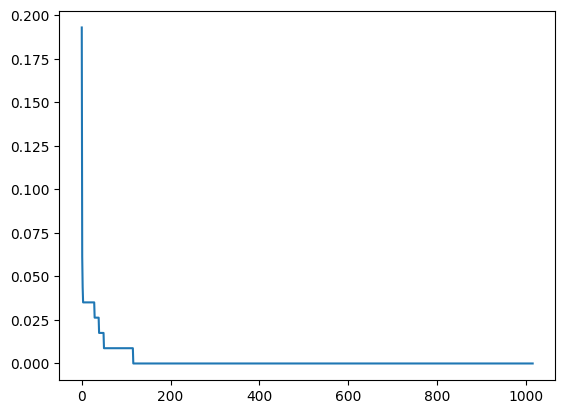

In [304]:
bayesian_model = BayesianLogisticRegression(sigma = 1)
loss = bayesian_model.fit(X = x_output, Y = y_output, X_test = x_test_output, Y_test = y_test_output, params = {"epsilon": .001, "learning_rate": .01})

plt.plot(loss)
y_pred = bayesian_model.predict(x_test_output)

print(bayesian_model.loss(y_pred, y_test_output))

## 2) **PCA**

In [9]:
# pca projection function for a given number of components
def pca_projection(dataset_x, components):
  pca = PCA(n_components = components)

  return pca.fit_transform(X = dataset_x)

# resulting projections
pca_projections_dict = {
    "10_pc": pca_projection(x_train, 10),
    "20_pc": pca_projection(x_train, 20),
    "30_pc": pca_projection(x_train, 30)
}

## 3) **Augmentation**

In [10]:
# function that augments the image
param = {
    "degree_min": -15,
    "degree_max": 15,
    "translate_min": -5,
    "translate_max": 5
}


# function that augments the image
def augment_image(images, labels, param):
  random_degree = rand.randrange(param["degree_min"], param["degree_max"] + 1)
  translation_x = rand.randrange(param["translate_min"], param["translate_max"] + 1)
  translation_y = rand.randrange(param["translate_min"], param["translate_max"] + 1)

  dataframe_shape = images.shape
  images_copy = images.copy()
  labels_copy = labels.copy()

  # loop through each image and augment it
  for idx in range(dataframe_shape[0]):
    # rotate and then translate
    img_np_array = images.iloc[idx, :].to_numpy().reshape(28, 28)
    rotated_img = rotate(img_np_array, random_degree)
    translate_img = np.roll(img_np_array, translation_x, axis = 1)
    transformed_img = np.roll(translate_img, translation_y, axis = 0)

    images_copy = images_copy._append(pd.Series(transformed_img.reshape(-1)))


# testing
  # print(random_degree)
  # plt.imshow(rotate(images.iloc[300, :].to_numpy().reshape(28, 28), 0))
  # plt.imshow(np.roll(images.iloc[300, :].to_numpy().reshape(28, 28), 5, axis = 0))


augment_image(x_train, y_train, param)


TypeError: Can only append a Series if ignore_index=True or if the Series has a name

## **Sources**
scikit-learn.org

https://stackoverflow.com/questions/53171057/numpy-matrix-rotation-for-any-degrees

https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.rotate.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html


